In [1]:
import yfinance as yf
#Get the data for EWC and EWA
ewc = yf.Ticker("EWC")
ewa = yf.Ticker("EWA")

ewc = ewc.history(start="2019-01-01" , end="2022-01-01")
ewa = ewa.history(start="2019-01-01" , end="2022-01-01")

ewc.to_csv("Stock_data/EWC.csv")
ewa.to_csv("Stock_data/EWA.csv")


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.vector_ar.vecm import coint_johansen as johansen_test
from statsmodels.tsa.stattools import coint as cadf_test
import datetime
from statsmodels.regression.linear_model import OLS as least_sqaures_regression
from statsmodels.tsa.stattools import adfuller
import numpy as np
from pykalman import KalmanFilter

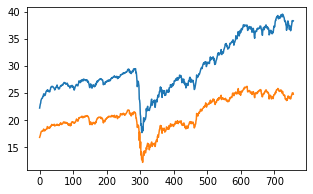

In [3]:
ewc = pd.read_csv("Stock_data/EWC.csv")
ewa = pd.read_csv("Stock_data/EWA.csv")


plt.figure(figsize=(5,3))
plt.plot(ewc["Open"])
plt.plot(ewa["Open"])
plt.show()


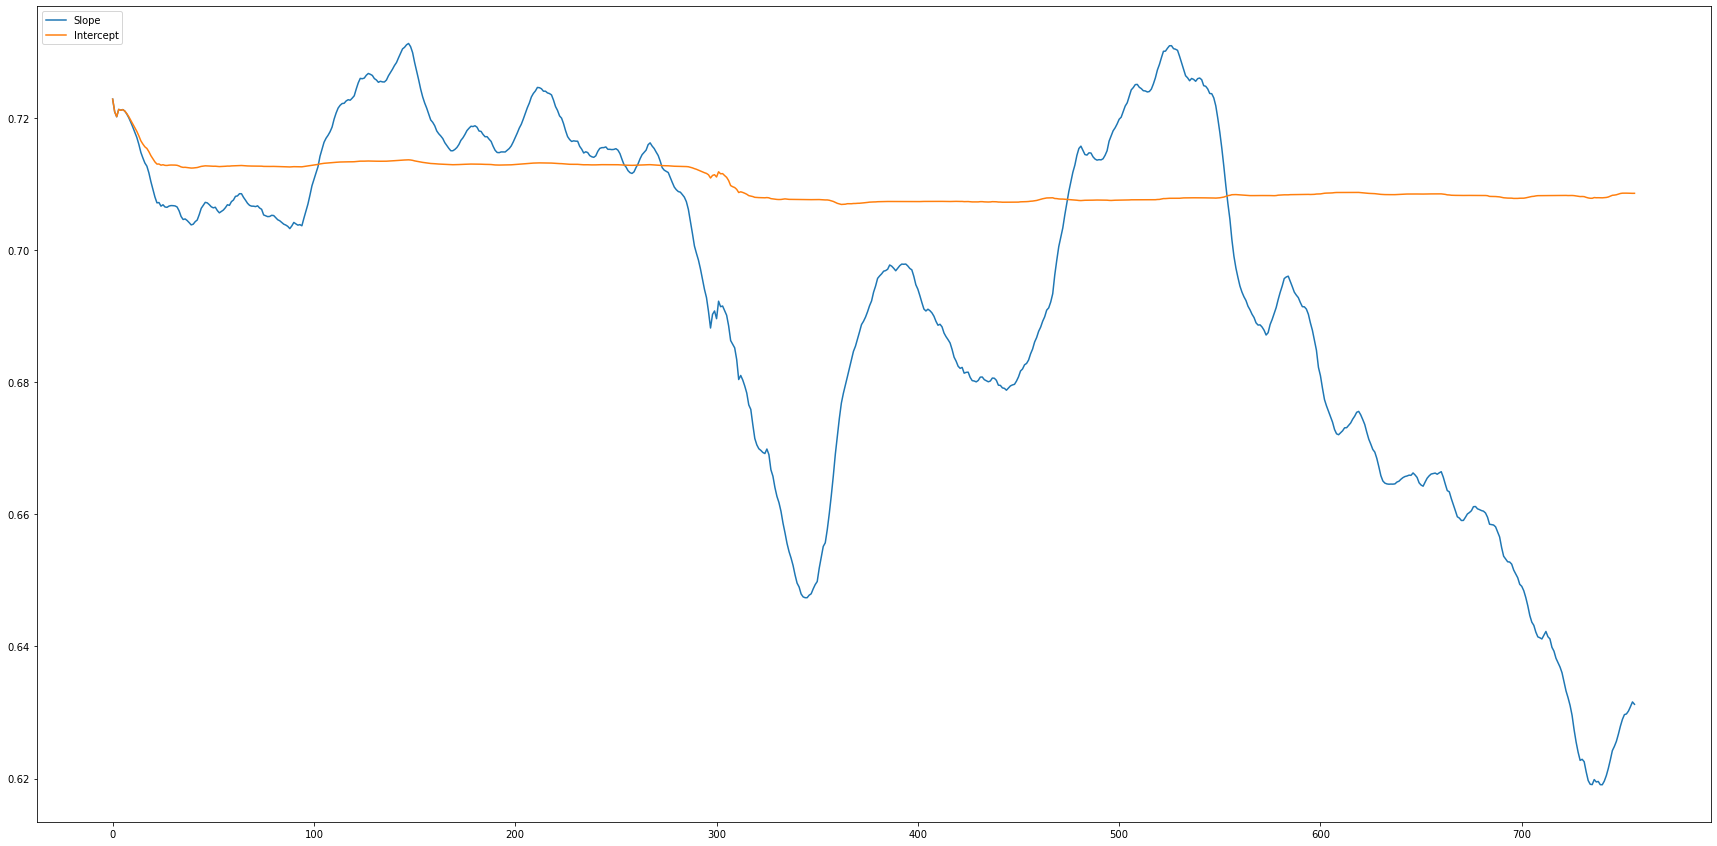

In [4]:
#Dynamic Linear Regression

"""
Utilise the Kalman Filter from the pyKalman package
to calculate the slope and intercept of the regressed
ETF prices.
"""
delta = 1e-5
trans_cov = delta / (1 - delta) * np.eye(2)
obs_mat = np.vstack([ewc["Open"], np.ones(ewc["Open"].shape)]).T[:, np.newaxis]

kf = KalmanFilter(
    n_dim_obs=1, 
    n_dim_state=2,
    initial_state_mean=np.zeros(2),
    initial_state_covariance=np.ones((2, 2)),
    transition_matrices=np.eye(2),
    observation_matrices=obs_mat,
    observation_covariance=1.0,
    transition_covariance=trans_cov
)

state_means, state_covs = kf.filter(ewa["Open"].values)

slope = state_means[:,0]
intercept = state_means[:,1]

plt.figure(figsize=(30,15))
plt.plot(slope, label="Slope")
plt.plot(intercept, label = "Intercept")
plt.legend(loc="upper left")
plt.show()

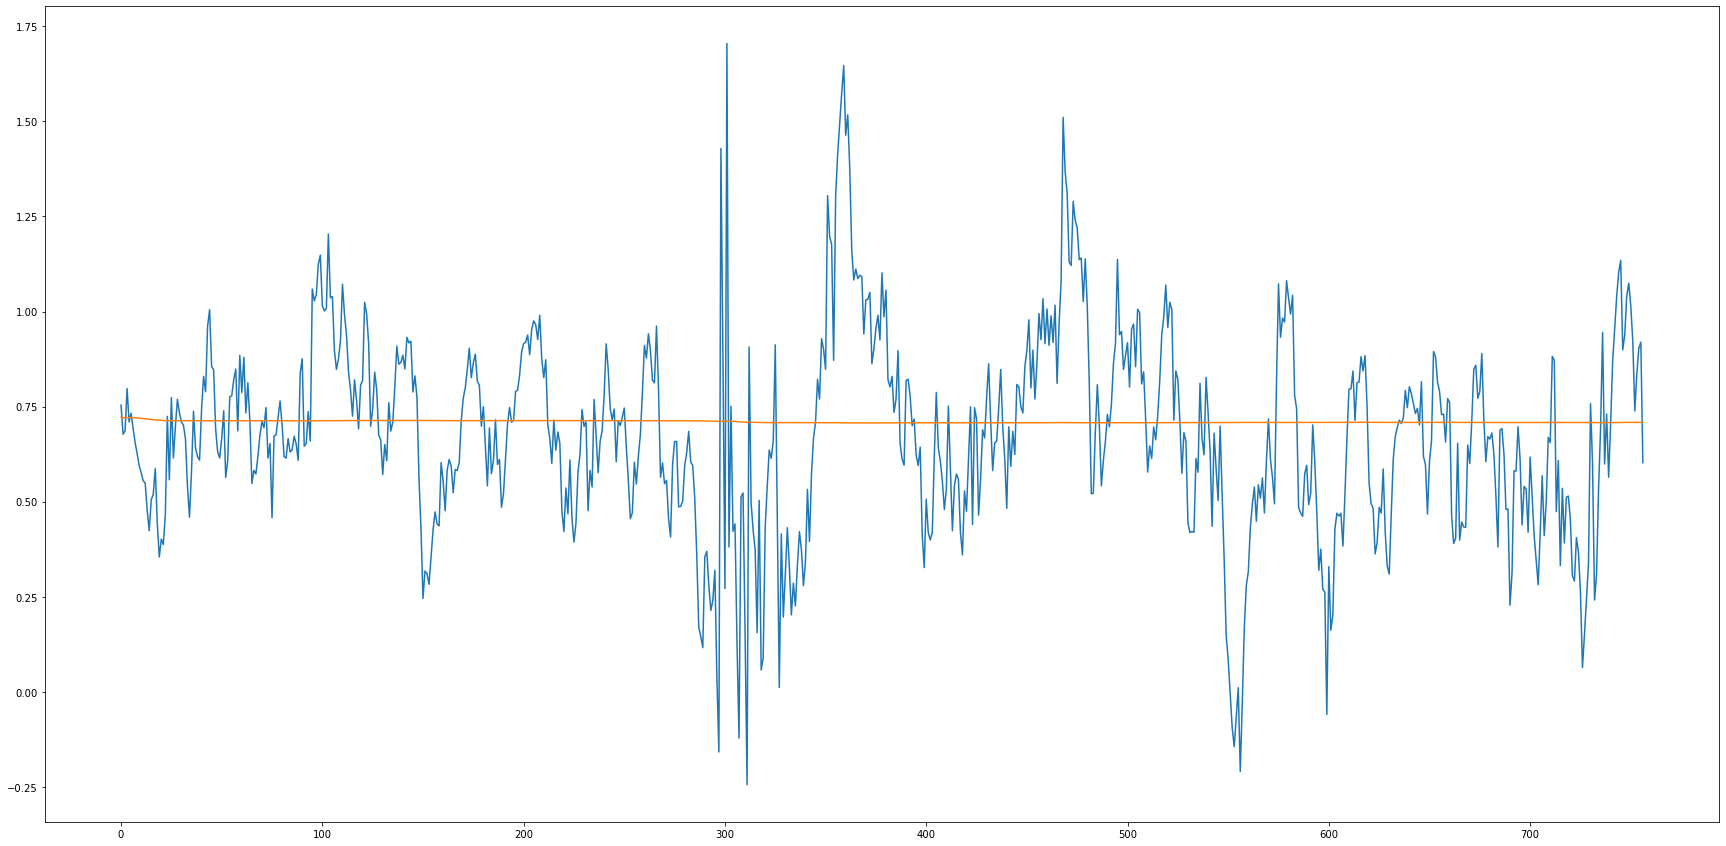

In [5]:
plt.figure(figsize=(30,15))
stationary_plot = pd.DataFrame()
stationary_plot["Plot"] = ewa["Open"] - slope * ewc["Open"]
plt.plot(stationary_plot["Plot"])
plt.plot(intercept, label = "Intercept")
#plt.savefig("stationary plot example" , dpi=200, bbox_inches="tight")


In [6]:
adfuller(stationary_plot["Plot"])

(-5.339154202137374,
 4.540538285389194e-06,
 11,
 745,
 {'1%': -3.4391580196774494,
  '5%': -2.8654273226340554,
  '10%': -2.5688400274762397},
 -654.0836774041775)

In [7]:
#find the halflife of reversion for the standard deviation lookback window
from statsmodels.tools.tools import add_constant
#Half life of mean reversion calculation
#y(t) - y(t-1) as the dependent variable
#y(t-1) as the independant variable


y = stationary_plot["Plot"] 
y_lagged = stationary_plot["Plot"] .shift(1)

dependent = y - y_lagged

y_lagged.iloc[0] = y_lagged.iloc[1]
dependent.iloc[0] = dependent.iloc[1]

model_1 = least_sqaures_regression(dependent, add_constant(y_lagged))
results_1 = model_1.fit()

print(results_1.params)

halflife = (-np.log(2)) / results_1.params[1]
print(halflife)

const    0.138055
Plot    -0.204871
dtype: float64
3.38334033940958


In [12]:
lookback = round(halflife) * 6

moving_variance = np.zeros([len(intercept)]) 
for i in range(lookback-1, len(moving_variance)):
    moving_var = 0
    
    for loop in range(lookback):
        moving_var += (stationary_plot["Plot"].iloc[i-loop] - intercept[i])**2 
    
    moving_var /= lookback
    moving_variance[i] = moving_var

moving_std = np.sqrt(moving_variance)

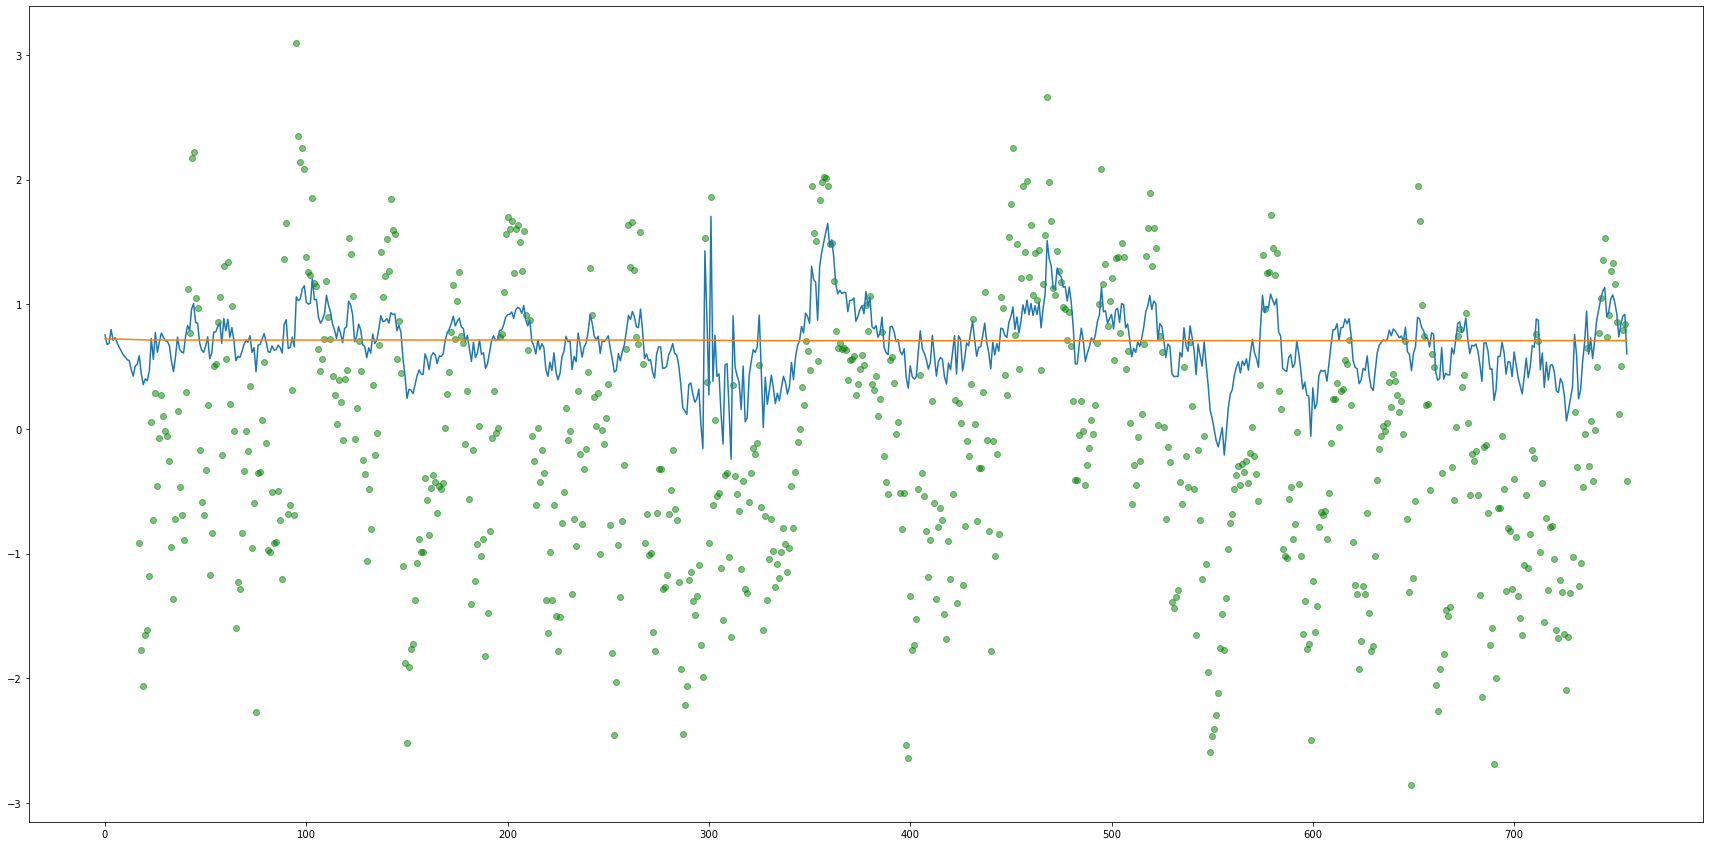

In [13]:
moving_z_score = (stationary_plot["Plot"]- intercept)/moving_std

plt.figure(figsize=(30,15))
plt.plot(stationary_plot["Plot"], label="Series")
plt.plot(intercept, label = "Intercept")
plt.scatter([x for x in range(len(moving_z_score))],moving_z_score, label="z_score", c="g",alpha=0.5)
plt.savefig("Standard deviation demo", dpi=400, bbox_inches='tight')
plt.show()

4695.40489010766


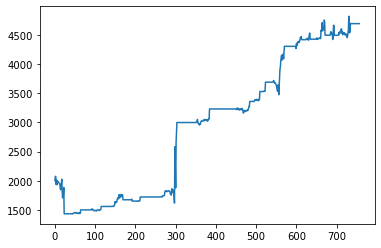

In [10]:
#So visually we can try to guess at an entry z-score of +-1.6
#according to our hedge ratio we should be long in ewa and short in ewc when our stionary plot is long, and flip when it is short
entryScore = 1.7
exitScore = 0


cash = 2000
starting = cash
equity = cash

short_price = 0
long_price = 0

long_holdings = 0
short_holdings = 0

history = [] #[(amount, buy or sell , purchase price / sell price)]
sell_factor = 1

equity_vals = []
#assume short allowance is the same as long allowance

#build the trade simulation
for i in range(len(moving_z_score)):
    
    price = stationary_plot["Plot"].iloc[i]
    current_score = moving_z_score[i]

    if  exitScore - 0.1 < current_score < exitScore + 0.1:

        if long_holdings != 0:
            #realize our long position
            cash += (price - long_price) * long_holdings
            long_holdings = 0
            history.append((price, long_price, "Long"))
        
        if short_holdings != 0:
            #realize our short position
            cash += (short_price - price) * short_holdings
            short_holdings = 0
            history.append((price, short_price, "Short"))

    #enter long
    if current_score < -entryScore:
        #checck if we are holding short shares
        if short_holdings != 0:
            #realize our short position
            cash += (short_price - price) * short_holdings
            short_holdings = 0
            history.append((price, short_price, "Short"))
             
        
            if cash < price:
                amount = 0
            else:
                amount = (cash // ewa["Open"].iloc[i]) 

        #update cash balance
        cash -= amount * price
        
        #update avg long price and number of holdings
        long_price = long_price*long_holdings +  price*amount
        long_holdings += amount
        if long_holdings != 0:
            long_price /= long_holdings   
        
            
    #enter short
    elif current_score > entryScore:
        if long_holdings != 0:
            #realize our long position
            cash += (price - long_price) * long_holdings
            long_holdings = 0
            history.append((price, long_price, "Long"))
        
        if short_holdings != 0:
            amount = 0
        else:
            amount = (cash // ewc["Open"].iloc[i])  
        #update balance
        cash += amount * price

        short_price = short_holdings*short_price + price*amount
        short_holdings += amount
        if short_holdings != 0:
            short_price /= short_holdings
        


    #equity calculation at the end
    equity = cash + long_holdings*price - short_holdings*price
    equity_vals.append(equity)   
          
print(equity)    
plt.plot(equity_vals)


In [11]:
for item in history:
    if item[2] == "Long":
        if item[0] < item[1]:
            print("Bad trade", item)

    else:
        if item[1] < item[0]:
            print("Bad trade", item)
print(len(history))

28
